# 1. A database for a time-domain survey (Part II): SQL queries

Using colorblind palette. Juan says OK !


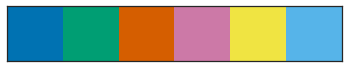

In [3]:
##     Include all required python-related packages     ##
import sqlite3 as sq #handle sql databases
import pandas as pd #dataframes
import numpy as np #deal with arrays
import matplotlib.pyplot as plt #plotting
import seaborn as sns # statistics
#to show plots in line
%matplotlib inline 
#General set-up of plots
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 15
rcParams['font.size'] = 15
sns.set(style="white")

print "Using colorblind palette. Juan says OK !"
sns.palplot(sns.color_palette("colorblind"))
sns.set_palette("colorblind")

### Opening the connection to database: sqlite needed

In [4]:
con = sq.connect('Database_s1848151.db')

These are some tests to the data base just to see if some basic information are saved correctly

In [93]:
#try1 = con.execute("SELECT name FROM sqlite_master WHERE type='table'")
#print ' Tables in the database:'
#for row in try1: 
#    print row

#try2 = con.execute("SELECT dat.Filename as fn FROM Info as dat")
#for row in try2: 
#    print row
    
#try3= con.execute("""SELECT COUNT(dat.StarID)
#                  FROM Data as dat WHERE dat.ID=13 AND Class=-1""")
#for row in try3: 
#    print row

#try4=con.execute("""select sql from sqlite_master where type = 'table' and name = 'Info'""")
#for row in try4: 
#    print row


try5=con.execute("""SELECT Info.Filter FROM Info WHERE Info.FieldID=1 ORDER BY Filter""")
for row in try5: 
    print row

(u'H',)
(u'J',)
(u'Ks',)
(u'Ks',)
(u'Ks',)
(u'Y',)
(u'Z',)


## Queries
#### R1:  Find all images observed between MJD=56800 and MJD=57300 and give me the number of stars detected with S/N > 5 in each image. 



In [63]:
# Write string for query
R1_str = """SELECT filename, realfilename, mjd, numstars FROM (SELECT inf.Filename as filename,
        inf.Realfilename as realfilename, 
        inf.MJD mjd, COUNT(dat.StarID) as numstars 
        FROM Info as inf, Data as dat
        WHERE dat.ID == inf.ID
        AND (dat.Flux1/dat.dFlux1) > 5
        AND dat.Class=-1
        GROUP BY inf.Filename
        )
        WHERE mjd>56800 AND mjd<57300
        ORDER BY mjd
        """

# Execute query
R1 = con.execute(R1_str)
number=0
# Show information
for row in R1: 
    print "FileName: {0}. RealFileName: {1}. MJD: {2}. Stars: {3}.".format(row[0], 
    row[1], row[2], row[3])
    number = number + row[3]

print "Total number of stars: {}".format(number)

FileName: Ks-ADP.2016-05-25T15:33:43.377.fits. RealFileName: Field-1-Ks-E003.fits. MJD: 56829.0390512. Stars: 7888.
FileName: H-ADP.2017-01-18T11:58:35.780.fits. RealFileName: Field-1-H.fits. MJD: 57257.044108. Stars: 7982.
FileName: J-ADP.2017-01-18T11:58:35.781.fits. RealFileName: Field-1-J.fits. MJD: 57257.0504323. Stars: 7022.
FileName: H-ADP.2017-01-18T11:58:35.780b.fits. RealFileName: Field-2-H.fits. MJD: 57258.044108. Stars: 7725.
FileName: H-ADP.2017-01-18T11:58:35.780c.fits. RealFileName: Field-3-H.fits. MJD: 57258.044108. Stars: 8022.
FileName: J-ADP.2017-01-18T11:58:35.781b.fits. RealFileName: Field-2-J.fits. MJD: 57258.0504323. Stars: 7354.
FileName: J-ADP.2017-01-18T11:58:35.781c.fits. RealFileName: Field-3-J.fits. MJD: 57258.0504323. Stars: 7248.
FileName: Y-ADP.2017-01-18T11:58:36.901.fits. RealFileName: Field-1-Y.fits. MJD: 57267.1596647. Stars: 6806.
FileName: Z-ADP.2017-01-18T11:58:36.905.fits. RealFileName: Field-1-Z.fits. MJD: 57267.1671072. Stars: 6477.
FileName: Y

#### R2:  Find the objects that have J-H > 1.5

In [90]:
# Write string for query
R2_str= """ SELECT Color.ColorJH, Color.FieldID FROM Color
              WHERE Color.ColorJH > 1.5 ORDER BY Color.StarID
          """
# Execute query in using pandas as the result is more than 20 entries and need to be plotted
R2 = pd.read_sql_query(R2_str, con)
print '# objects that fulfil color J-H > 1.5:', len(R2.colorJH)
#R2

# objects that fulfil color J-H > 1.5: 7154


Text(0.5,0,u'ID')

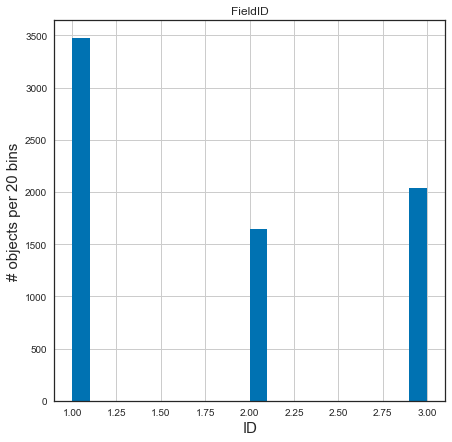

In [69]:
#Plot histogram
nbins=20
R2.hist(column='FieldID', bins=nbins, figsize=(7,7))
#plt.yscale('log')
plt.ylabel("# objects per {} bins".format(nbins), size=15)
plt.xlabel("ID", size=15)

Text(0.5,1,u'KDE ')

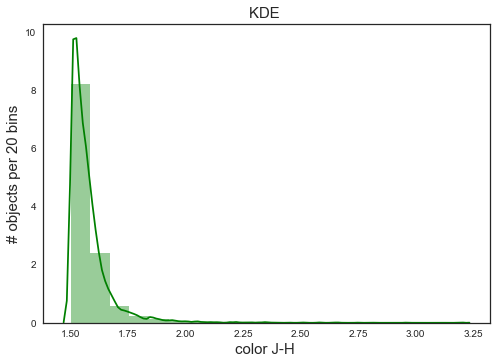

In [66]:
#Plot simple kde
sns.distplot(R2.colorJH.values, bins=nbins, color="g")
plt.ylabel("# objects per {} bins".format(nbins), size=15)
plt.xlabel("color J-H ", size=15)
plt.title("KDE ", size=15)

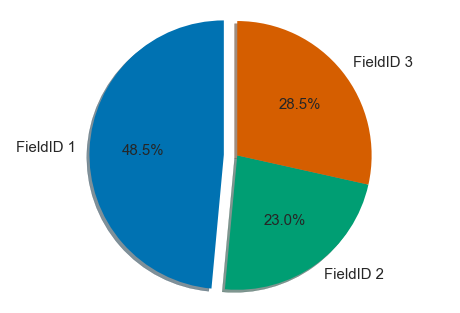

In [118]:
fig1, ax1 = plt.subplots()
explode = (0.1, 0, 0) 
sizes = [len(R2.FieldID[R2.FieldID==1]), len(R2.FieldID[R2.FieldID==2]), len(R2.FieldID[R2.FieldID==3])]
labels = ["FieldID 1", "FieldID 2", "FieldID 3"]
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)
texts[2].set_fontsize(15)

####R3:  Find the objects where Ks differs by more than 20 times the flux uncertainty from the mean flux. 

In [5]:
#Simple query to know how many ID with FieldID are:
field_number_R2=1
ks_per_field_str= """SELECT Info.ID from Info where Info.Filter="Ks" and Info.FieldID={}""".format(field_number_R2)
ks_per_field= con.execute(ks_per_field_str)
for row in ks_per_field:
    print "ID: {0}".format(row[0])

ID: 4
ID: 5
ID: 6


In [ ]:
#Write string query: I select by Fields for convenience as the results are very large
R3_str_1 = """SELECT total.StarID, total.Flux1 FROM Data as total WHERE total.Filter="Ks"
        AND total.FieldID == {} 
        AND ABS( (SELECT AVG(sub.Flux1) FROM Data as sub WHERE sub.Filter="Ks"
        AND sub.StarID == total.StarID GROUP BY sub.StarID) )  >  ABS(20*total.dFlux1)
        GROUP BY total.StarID
        ORDER BY total.StarID""".format(1)

R3_str_2 = """SELECT total.StarID, total.Flux1 FROM Data as total WHERE total.Filter="Ks"
        AND total.FieldID == {} 
        AND ABS( (SELECT AVG(sub.Flux1) FROM Data as sub WHERE sub.Filter="Ks"
        AND sub.StarID == total.StarID GROUP BY sub.StarID) )  >  ABS(20*total.dFlux1)
        GROUP BY total.StarID
        ORDER BY total.StarID""".format(2)

R3_str_3 = """SELECT total.StarID, total.Flux1 FROM Data as total WHERE total.Filter="Ks"
        AND total.FieldID == {} 
        AND ABS( (SELECT AVG(sub.Flux1) FROM Data as sub WHERE sub.Filter="Ks"
        AND sub.StarID == total.StarID GROUP BY sub.StarID) )  >  ABS(20*total.dFlux1)
        GROUP BY total.StarID
        ORDER BY total.StarID""".format(3)

# Execute query using pandas as the result may be larger than 20 entries
R3_1 = pd.read_sql_query(R3_str_1, con)
R3_2 = pd.read_sql_query(R3_str_2, con)
R3_3 = pd.read_sql_query(R3_str_3, con)

In [5]:
print "# Objects in field {0} found with criterium is: {1}".format(1, len(R3_1))
print "# Objects in field {0} found with criterium is: {1}".format(2, len(R3_2))
print "# Objects in field {0} found with criterium is: {1}".format(3, len(R3_3))

# Objects in field 1 found with criterium is: 7884
# Objects in field 2 found with criterium is: 6529
# Objects in field 3 found with criterium is: 6908


(array([ -50000.,       0.,   50000.,  100000.,  150000.,  200000.,
         250000.,  300000.]), <a list of 8 Text yticklabel objects>)

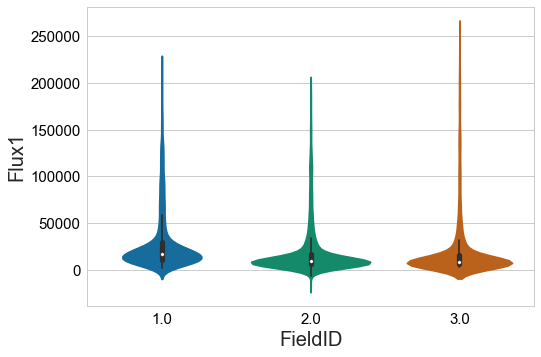

In [32]:
#Graphical representation of the flux1 selected...
FieldID=np.ones(len(R3_1))
FieldID2=2*np.ones(len(R3_2))
FieldID3=3*np.ones(len(R3_3))

fields=np.concatenate([FieldID, FieldID2, FieldID3])
data=np.concatenate([R3_1.Flux1, R3_2.Flux1, R3_3.Flux1])

plt.figure()
sns.violinplot(x=fields, y=data)
plt.ylabel("Flux1", fontsize=20)
plt.xlabel("FieldID", fontsize=20)
plt.xticks(color='k', size=15)
plt.yticks(color='k', size=15)


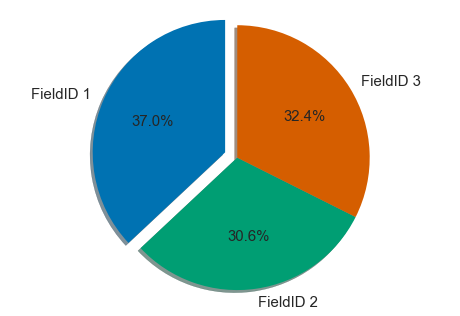

In [119]:
#Pie chart as in the previous query
fig1, ax1 = plt.subplots()
explode = (0.1, 0, 0) 
sizes = [len(R3_1.StarID), len(R3_2.StarID), len(R3_3.StarID)]
labels = ["FieldID 1", "FieldID 2", "FieldID 3"]
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)
texts[2].set_fontsize(15)

####R4:  Find all catalogues that exist for a given field.

In [72]:
# ONE PER ONE ---> Choose field: possible options are 1, 2, and 3.
field_number_R4 = 1

# Write string for query
R4_str = """ SELECT fieldident, filename, realfilename, ident FROM (
        SELECT inf.Filename as filename, inf.Realfilename as realfilename,
        inf.FieldID as fieldident, inf.ID as ident
        FROM Info as inf
        ) 
        WHERE fieldident == {}
        """.format(field_number_R4)

# Execute query for J
R4 = con.execute(R4_str)

print "Field: {}".format(field_number_R4)
for row in R4:
    print "Filename: {0}. Realfilename: {1}. ID: {2}".format(row[1], row[2], row[3])

Field: 1
Filename: Z-ADP.2017-01-18T11:58:36.905.fits. Realfilename: Field-1-Z.fits. ID: 1
Filename: J-ADP.2017-01-18T11:58:35.781.fits. Realfilename: Field-1-J.fits. ID: 2
Filename: H-ADP.2017-01-18T11:58:35.780.fits. Realfilename: Field-1-H.fits. ID: 3
Filename: Ks-ADP.2016-05-25T15:33:39.546.fits. Realfilename: Field-1-Ks-E002.fits. ID: 4
Filename: Ks-ADP.2017-01-18T11:58:39.907.fits. Realfilename: Field-1-Ks-E001.fits. ID: 5
Filename: Ks-ADP.2016-05-25T15:33:43.377.fits. Realfilename: Field-1-Ks-E003.fits. ID: 6
Filename: Y-ADP.2017-01-18T11:58:36.901.fits. Realfilename: Field-1-Y.fits. ID: 7


In [73]:
# SHOW ALL ---> For-loop until 3
field_limit = 3

for element in range (1, field_limit+1):

    # Write string for query
    R4_str_loop = """ SELECT fieldident, filename, realfilename, ident FROM (
        SELECT inf.Filename as filename, inf.Realfilename as realfilename,
        inf.FieldID as fieldident, inf.ID as ident
        FROM Info as inf
        ) 
        WHERE fieldident == {}
        """.format(element)

    # Execute query for J
    R4_loop = con.execute(R4_str_loop)

    print "Field: {}".format(element)
    for row in R4_loop:
        print "Filename: {0}. Realfilename: {1}. ID: {2}".format(row[1], row[2], row[3])

Field: 1
Filename: Z-ADP.2017-01-18T11:58:36.905.fits. Realfilename: Field-1-Z.fits. ID: 1
Filename: J-ADP.2017-01-18T11:58:35.781.fits. Realfilename: Field-1-J.fits. ID: 2
Filename: H-ADP.2017-01-18T11:58:35.780.fits. Realfilename: Field-1-H.fits. ID: 3
Filename: Ks-ADP.2016-05-25T15:33:39.546.fits. Realfilename: Field-1-Ks-E002.fits. ID: 4
Filename: Ks-ADP.2017-01-18T11:58:39.907.fits. Realfilename: Field-1-Ks-E001.fits. ID: 5
Filename: Ks-ADP.2016-05-25T15:33:43.377.fits. Realfilename: Field-1-Ks-E003.fits. ID: 6
Filename: Y-ADP.2017-01-18T11:58:36.901.fits. Realfilename: Field-1-Y.fits. ID: 7
Field: 2
Filename: Z-ADP.2017-01-18T11:58:36.905b.fits. Realfilename: Field-2-Z.fits. ID: 8
Filename: J-ADP.2017-01-18T11:58:35.781b.fits. Realfilename: Field-2-J.fits. ID: 9
Filename: H-ADP.2017-01-18T11:58:35.780b.fits. Realfilename: Field-2-H.fits. ID: 10
Filename: Ks-ADP.2016-05-25T15:33:39.546b.fits. Realfilename: Field-2-Ks-E001.fits. ID: 11
Filename: Y-ADP.2017-01-18T11:58:36.901b.fits.

#### R5: For a given field, retrieve the Y, Z, J, H and Ks magnitudes for all stars with S/N > 30 in Y, Z, J, H and Ks 

In [74]:
# Write string for query. In this case, I choose field_number 1 and make the filtering according
#to S/N >30

field_number_R5 = 1

R5_str_filtering = """
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND dat.Class=-1 AND inf.ID == dat.ID AND (dat.Flux1/dat.dFlux1) > 30
        ORDER BY ident
        """.format(field_number_R5)
# Execute query
R5_filtering = con.execute(R5_str_filtering)

# Write string for query. In this case, I repeat the query without being filtered by S/N

R5_str_all = """
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.ID == dat.ID AND dat.Class=-1
        ORDER BY ident
        """.format(field_number_R5)


# Create panda data frame
R5_filtering_df = pd.read_sql_query(R5_str_filtering, con)
R5_all_df = pd.read_sql_query(R5_str_all, con)

# Show print:
print '# stars that fulfil color S/N > 30 in every filter:', len(R5_filtering_df.magnitude1)
print '# stars in every filter:', len(R5_all_df.magnitude1)

# stars that fulfil color S/N > 30 in every filter: 34529
# stars in every filter: 50229


In [96]:
#Let's check that I am able to reproduce same results in python and SQL
print "Number of stars per filter using Python:"
print '# stars that fulfil color S/N > 30 in Z:', len(R5_filtering_df[(R5_filtering_df.filterident == "Z")].magnitude1.values)
print '# stars that fulfil color S/N > 30 in Y:', len(R5_filtering_df[(R5_filtering_df.filterident == "Y")].magnitude1.values)
print '# stars that fulfil color S/N > 30 in J:', len(R5_filtering_df[(R5_filtering_df.filterident == "J")].magnitude1.values)
print '# stars that fulfil color S/N > 30 in H:', len(R5_filtering_df[(R5_filtering_df.filterident == "H")].magnitude1.values)
print '# stars that fulfil color S/N > 30 in Ks:', len(R5_filtering_df[(R5_filtering_df.filterident == "Ks")].magnitude1.values)
print '# stars in Z:', len(R5_all_df[(R5_all_df.filterident == "Z")].magnitude1.values)
print '# stars in Y:', len(R5_all_df[(R5_all_df.filterident == "Y")].magnitude1.values)
print '# stars in J:', len(R5_all_df[(R5_all_df.filterident == "J")].magnitude1.values)
print '# stars in H:', len(R5_all_df[(R5_all_df.filterident == "H")].magnitude1.values)
print '# stars in Ks:', len(R5_all_df[(R5_all_df.filterident == "Ks")].magnitude1.values)

print "\nNumber of stars per filter using SQL:"
R5_Z = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "Z" AND dat.Class=-1 AND inf.ID == dat.ID AND (dat.Flux1/dat.dFlux1) > 30
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars that fulfil color S/N > 30 in Z:', len(R5_Z)
R5_Y = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND dat.Class=-1 AND inf.Filter = 'Y' AND inf.ID == dat.ID AND (dat.Flux1/dat.dFlux1) > 30
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars that fulfil color S/N > 30 in Y:', len(R5_Y)
R5_J = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "J" AND dat.Class=-1 AND inf.ID == dat.ID AND (dat.Flux1/dat.dFlux1) > 30
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars that fulfil color S/N > 30 in J:', len(R5_J)
R5_H = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "H" AND dat.Class=-1 AND inf.ID == dat.ID AND (dat.Flux1/dat.dFlux1) > 30
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars that fulfil color S/N > 30 in H:', len(R5_H)
R5_Ks = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "Ks" AND dat.Class=-1 AND inf.ID == dat.ID AND (dat.Flux1/dat.dFlux1) > 30
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars that fulfil color S/N > 30 in Ks:', len(R5_Ks)


R5_Za = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "Z" AND dat.Class=-1 AND inf.ID == dat.ID
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars in Z:', len(R5_Za)
R5_Ya = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND dat.Class=-1 AND inf.Filter = 'Y' AND inf.ID == dat.ID
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars in Y:', len(R5_Ya)
R5_Ja = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "J" AND dat.Class=-1 AND inf.ID == dat.ID
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars in J:', len(R5_Ja)
R5_Ha = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "H" AND dat.Class=-1 AND inf.ID == dat.ID
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars in H:', len(R5_Ha)
R5_Ksa = pd.read_sql_query("""
        SELECT inf.ID as ident, inf.FieldID as fieldident, inf.Filter as filterident,
        dat.Mag1 as magnitude1, dat.StarID as starident
        FROM Info as inf, Data as dat
        WHERE inf.FieldID == {} AND inf.Filter == "Ks" AND dat.Class=-1 AND inf.ID == dat.ID
        ORDER BY ident
        """.format(field_number_R5), con)
print '# stars in Ks:', len(R5_Ksa)


Number of stars per filter using Python:
# stars that fulfil color S/N > 30 in Z: 3740
# stars that fulfil color S/N > 30 in Y: 4218
# stars that fulfil color S/N > 30 in J: 4829
# stars that fulfil color S/N > 30 in H: 6356
# stars that fulfil color S/N > 30 in Ks: 15386
# stars in Z: 6509
# stars in Y: 6810
# stars in J: 7022
# stars in H: 7982
# stars in Ks: 21906

Number of stars per filter using SQL:
# stars that fulfil color S/N > 30 in Z: 3740
# stars that fulfil color S/N > 30 in Y: 4218
# stars that fulfil color S/N > 30 in J: 4829
# stars that fulfil color S/N > 30 in H: 6356
# stars that fulfil color S/N > 30 in Ks: 15386
# stars in Z: 6509
# stars in Y: 6810
# stars in J: 7022
# stars in H: 7982
# stars in Ks: 21906


(11, 19)

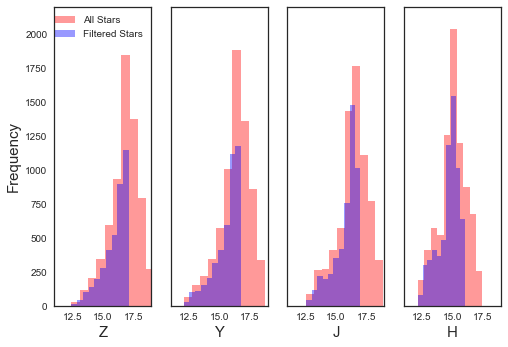

In [97]:
#Plot easily for Y, Z, J, H
fig, axs = plt.subplots(1,4)
ax = axs.ravel()
fig.figsize=(200, 200)
ylim = (0,2200)
xlim = (11, 19)

ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].hist(R5_all_df[(R5_all_df.filterident == "Z")].magnitude1.values, histtype='stepfilled', color='red', alpha=0.4, label = "All Stars")
ax[0].hist(R5_filtering_df[(R5_filtering_df.filterident == "Z")].magnitude1.values, histtype='stepfilled', color='blue', alpha=0.4, label = "Filtered Stars")
ax[0].set_xlabel('Z', fontsize=15)
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)
ax[0].legend()

ax[1].hist(R5_all_df[(R5_all_df.filterident == "Y")].magnitude1.values, histtype='stepfilled', color='red', alpha=0.4)
ax[1].hist(R5_filtering_df[(R5_filtering_df.filterident == "Y")].magnitude1.values, histtype='stepfilled', color='blue', alpha=0.4)
ax[1].set_xlabel('Y', fontsize=15)
ax[1].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_yticklabels([])

ax[2].hist(R5_all_df[(R5_all_df.filterident == "J")].magnitude1.values, histtype='stepfilled', color='red', alpha=0.4)
ax[2].hist(R5_filtering_df[(R5_filtering_df.filterident == "J")].magnitude1.values, histtype='stepfilled', color='blue', alpha=0.4)
ax[2].set_xlabel('J', fontsize=15)
ax[2].set_ylim(ylim)
ax[2].set_yticklabels([])
ax[2].set_xlim(xlim)

ax[3].hist(R5_all_df[(R5_all_df.filterident == "H")].magnitude1.values, histtype='stepfilled', color='red', alpha=0.4)
ax[3].hist(R5_filtering_df[(R5_filtering_df.filterident == "H")].magnitude1.values, histtype='stepfilled', color='blue', alpha=0.4)
ax[3].set_xlabel('H', fontsize=15)
ax[3].set_ylim(ylim)
ax[3].set_yticklabels([])
ax[3].set_xlim(xlim)


In [98]:
#Plot for Ks: simple query to know how many ID with FieldID are:
R5_ks_per_field_str= """SELECT Info.ID from Info where Info.Filter="Ks" and Info.FieldID={}""".format(field_number_R5)
R5_ks_per_field= con.execute(R5_ks_per_field_str)
for row in R5_ks_per_field:
    print "ID: {0}".format(row[0])

ID: 4
ID: 5
ID: 6


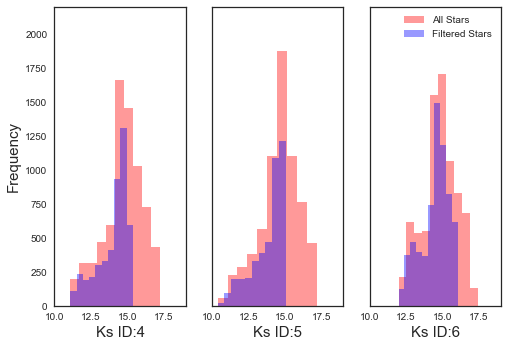

In [99]:
#Plot 3 Ks
Ks=R5_all_df[R5_all_df.filterident=="Ks"]
Ks4=Ks[Ks.ident==4].magnitude1.values
Ks5=Ks[Ks.ident==5].magnitude1.values
Ks6=Ks[Ks.ident==6].magnitude1.values


Ksf=R5_filtering_df[R5_filtering_df.filterident=="Ks"]
Ks4f=Ksf[Ksf.ident==4].magnitude1.values
Ks5f=Ksf[Ksf.ident==5].magnitude1.values
Ks6f=Ksf[Ksf.ident==6].magnitude1.values

#Plot easily for Y, Z, J, H
fig, axs = plt.subplots(1,3)
ax = axs.ravel()
fig.figsize=(200, 500)
ylim = (0,2200)
xlim = (10, 19)

ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].hist(Ks4, histtype='stepfilled', color='red', alpha=0.4)
ax[0].hist(Ks4f, histtype='stepfilled', color='blue', alpha=0.4)
ax[0].set_xlabel('Ks ID:4', fontsize=15)
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)

ax[1].hist(Ks5, histtype='stepfilled', color='red', alpha=0.4)
ax[1].hist(Ks5f, histtype='stepfilled', color='blue', alpha=0.4)
ax[1].set_xlabel('Ks ID:5', fontsize=15)
ax[1].set_ylim(ylim)
ax[1].set_yticklabels([])
ax[1].set_xlim(xlim)

ax[2].hist(Ks6, histtype='stepfilled', color='red', alpha=0.4, label="All Stars")
ax[2].hist(Ks6f, histtype='stepfilled', color='blue', alpha=0.4, label="Filtered Stars")
ax[2].set_xlabel('Ks ID:6', fontsize=15)
ax[2].set_ylim(ylim)
ax[2].set_yticklabels([])
ax[2].set_xlim(xlim)
ax[2].legend()
plt.show()